# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

('ZW', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(4032, 144)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Spread', 'CL_Open', 'CL_High', 'CL_Low', 'CL_Close',
       ...
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', '^VIX_Volume', '^VIX_Spread'],
      dtype='object', length=144)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02


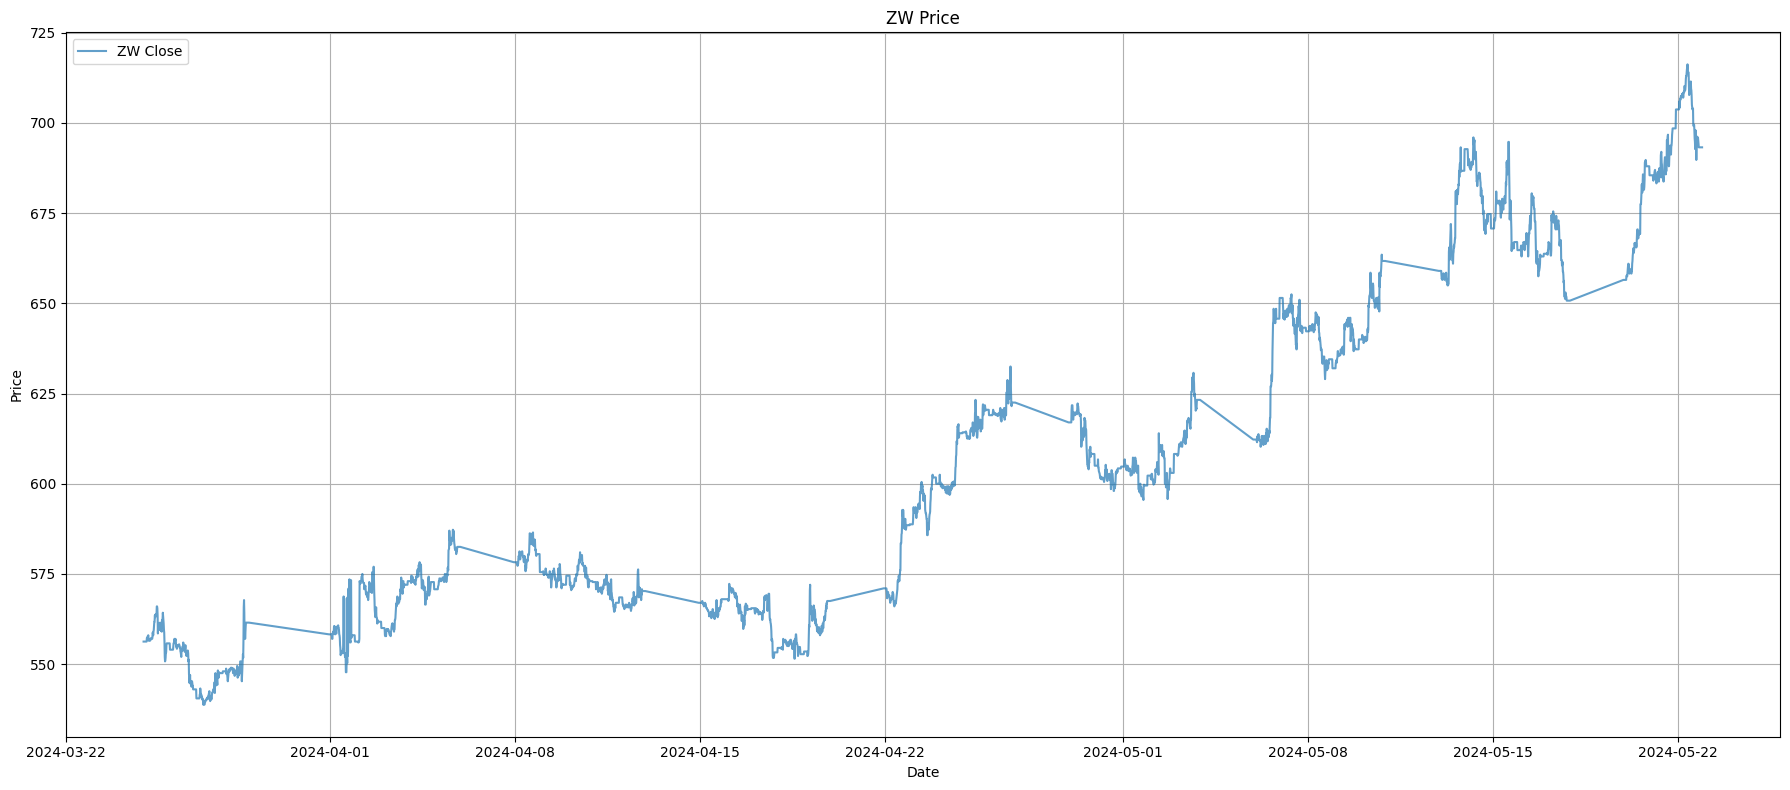

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

## Intra-Day Mean Reversion

https://learning.oreilly.com/library/view/algorithmic-trading-winning/9781118746912/OEBPS/9781118746912_epub_c02.htm#c02-sec1-0001

Using Augmented Dickey-Fuller (ADF) for stationarity:

$\Delta y(t) = \alpha + \beta t + \gamma y(t-1) + \delta_1 \Delta y(t-1) + \cdots + \delta_{p-1} \Delta y(t-p+1) + \epsilon_t$

where:
- $\Delta y(t) = y(t) - y(t-1)$ represents the first difference of the series.
- $y(t-1)$ is the lagged value of the series.
- $\beta t$, often set to zero in price series analyses, accounts for any deterministic time trend.
- $\delta_1, \delta_2, ..., \delta_{p-1}$ are coefficients for the lagged differences, adjusting for serial correlation.
- $\epsilon_t$ is the error term.


The null hypothesis $H_0: \gamma = 0$ suggests the presence of a unit root, indicating non-stationarity if the test statistic is $< 0.5$.

$\text{Test Statistic} = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})}$

where $\text{SE}(\hat{\gamma})$ is the standard error of $\hat{\gamma}$. 

Given a significance of $\alpha=0.05$, having critical values of $-2.86 \text{ to} -3.45$.
- $\text{SE} < 0 $ and $ p < 0.05 = \text{Mean reverting}$
- $\text{SE} > 0 $ and $ p < 0.05 = \text{Trending}$

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]

### Ornstein-Uhlenbeck (OU) 

Typically, a Hurst exponent significantly different from 0.5 indicates long-term memory (H > 0.5) or anti-persistent behavior (H < 0.5).



In [7]:
from quant_equations import *

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 1778
Hurst: 0.5298573922477304


The variance ratio (VR) test is used to determine if a time series follows a random walk and its scaling. The variance ratio is defined as:

`z(t)` is the value of the time series at time \( t \).  
`z(t-\tau)` is the value of the time series at time \( t - \tau \), where \( \tau \) is a lag.  
`Var(x)` denotes the variance of the variable \( x \).

The formula is:

$$
\frac{\text{Var}(z(t) - z(t-\tau))}{\tau \, \text{Var}(z(t) - z(t-1))}
$$

- VR≈1: Consistent with a random walk.
- VR>1: Indicates positive serial correlation (momentum).
- VR<1: Indicates negative serial correlation (mean reversion).

and test statistics:
- Is heteroskedasticity (variance changing over time).
- Is autocorrelation (returns at different times being correlated).

In [8]:
vr, ts1, p_value1, ts2, p_value2 = var_ratio(target_fut_df, f"{TARGET_FUT}_Close")
print(f"Variance Ratio: {vr}")
print(f"Test Statistic 1: {ts1} at P-Value 1: {p_value1:.12f}")
print(f"Test Statistic 2: {ts2} at P-Value 2: {p_value2:.12f}")

Variance Ratio: 0.5343030715082756
Test Statistic 1: -2.5799498653146355 at P-Value 1: 0.009881465973
Test Statistic 2: -1.4777109738351035 at P-Value 2: 0.139485155852


# Bollinger Bands


## B%

- %B is below 0 when price is below the lower band
- %B equals 0 when price is at the lower band
- %B is between 0 and .50 when price is between the lower and middle band (20-day SMA)
- %B is between .50 and 1 when price is between the upper and middle band (20-day SMA)
- %B equals 1 when price is at the upper band
- %B is above 1 when price is above the upper band

In [9]:
from tqdm import tqdm
import itertools
import math
from scipy.stats import skew, kurtosis

from quant_equations import calc_annualized_sharpe, deflated_sharpe_ratio, modulate_std
from signals import signal_bollinger_bands

def bollinger_band_backtest(price_df, target_col, window, std_factor, delta=1e-3, ve=1e-2):
    df = price_df.copy()
    bb_df = signal_bollinger_bands(df, target_col, window, std_factor, delta=delta, ve=ve)

    df['MA'] = bb_df['MA']
    df['SD'] = bb_df['SD']
    df['U'] = bb_df['U']
    df['L'] = bb_df['L']
    df['SB'] = (df[target_col] < bb_df['L']).astype(int).diff().clip(0) * +1
    df['SS'] = (df[target_col] > bb_df['U']).astype(int).diff().clip(0) * -1
    df['SBS'] = (df[target_col] > bb_df['MA']).astype(int).diff().clip(0) * -1
    df['SSB'] = (df[target_col] < bb_df['MA']).astype(int).diff().clip(0) * +1

    df['Closed'] = 0
    df['Position'] = 0
    df['Ret'] = 0.
    entry = position = 0

    for i, row in df.iterrows():
        if (row['SBS'] == -1 and position == 1) or (row['SSB'] == 1 and position == -1):
            if position == 1:
                df.loc[i, 'Ret'] = (row[target_col] - entry) / entry
                df.loc[i, 'Closed'] = 1
            else:
                df.loc[i, 'Ret'] = (entry - row[target_col]) / entry
                df.loc[i, 'Closed'] = -1
            position = 0

        if (row['SB'] == 1 and position == 0) or (row['SS'] == -1 and position == 0):
            entry = row[target_col]
            position = 1 if row['SB'] == 1 else -1
        df.loc[i, 'Position'] = position

    df['cRets'] = (1 + df['Ret']).cumprod() - 1

    variance = df['Ret'].var()
    df['Drawdown'] = (1 + df['Ret']).cumprod().div((1 + df['Ret']).cumprod().cummax()) - 1
    max_drawdown = df['Drawdown'].min()
    drawdown_length = (df['Drawdown'] < 0).astype(int).groupby(df['Drawdown'].eq(0).cumsum()).cumsum().max()
    sharpe = calc_annualized_sharpe(df['Ret'], period=INTERVAL)
    trades = (df['Position'].diff().ne(0) & df['Position'].ne(0)).sum()

    stats_df = pd.DataFrame({
        "Window": [window],
        "Standard_Factor": [std_factor],
        "Cumulative_Returns": [df['cRets'].iloc[-1]],
        "Max Ret": [df['Ret'].max()],
        "Max Loss": [df['Ret'].min()],
        "Variance": [variance],
        "STD": [np.sqrt(variance)],
        "Max_Drawdown": [max_drawdown],
        "Drawdown_Length": [drawdown_length],
        "Sharpe": [sharpe],
        "Trades_Count": [trades],
        "Trades_per_Interval": [trades / len(df)],
        "Trading_Intervals": [len(df)],
        "Rets": [df['Ret'].to_numpy()],
        "Rets_Skew": [skew(df['Ret'].to_numpy())],
        "Rets_Kurt": [kurtosis(df['Ret'].to_numpy())],
    })

    return df, stats_df

def param_search_bbs(df, target_col, initial_window=HALF_LIFE, window_factor = 1.5, window_min = 4, intial_std_adjustment=0.5, hurst=HURST):
    assert initial_window > window_min

    num_steps = int(math.log(initial_window / window_min, window_factor)) + 1
    windows = [int(initial_window // (window_factor**i)) for i in range(num_steps)]
    std_adjustments = [intial_std_adjustment/2, intial_std_adjustment, intial_std_adjustment * 1.5, intial_std_adjustment * 2]
    combinations = list(itertools.product(windows, std_adjustments))

    best_sharpe = -float('inf')
    best_sharpe_stats = None
    best_rets = -float('inf')
    best_rets_stats = None
    best_mdd = -float('inf')
    best_mdd_stats = None

    sharpes = []
    n_tests = len(combinations)

    for window, adjustment in tqdm(combinations, desc="param_search_bbs"):
        std_factor = modulate_std (hurst, intial_std_adjustment, adjustment)
        _, stats_df = bollinger_band_backtest(df, target_col, window,std_factor)

        stat = stats_df['Sharpe'].iloc[0]
        sharpes.append(stat)
        if stat > best_sharpe:
            best_sharpe = stat
            best_sharpe_stats = stats_df.copy()

        stat = stats_df['Cumulative_Returns'].iloc[0]
        if stat > best_rets:
            best_rets = stat
            best_rets_stats = stats_df.copy()

        stat = stats_df['Max_Drawdown'].iloc[0]
        if stat > best_mdd:
            best_mdd = stat
            best_mdd_stats = stats_df.copy()

    # We're datamining, we need to deflated the sharpe!
    for df in [best_sharpe_stats, best_rets_stats, best_mdd_stats]:
        df['Sharpe'] = deflated_sharpe_ratio(df['Sharpe'].iloc[0],
                                            len(df['Rets'].iloc[0]),
                                            df['Rets_Skew'].iloc[0],
                                            df['Rets_Kurt'].iloc[0],
                                            sharpes,
                                            n_tests)

    results_df = pd.concat([best_sharpe_stats.assign(Metric='Sharpe'),
                            best_rets_stats.assign(Metric='Cumulative Returns'),
                            best_mdd_stats.assign(Metric='Max Drawdown')],
                           ignore_index=True)

    return results_df


stats_df = param_search_bbs(futs_df, f'{TARGET_FUT}_Close', initial_window=HALF_LIFE, hurst=HURST)
cumret_df= stats_df[stats_df["Metric"] == "Cumulative Returns"]
BEST_WINDOW = cumret_df["Window"].values[0]
BEST_STD_FACTOR = cumret_df["Standard_Factor"].values[0]

stats_df.drop(columns=["Rets"])

param_search_bbs:  16%|█▌        | 10/64 [00:05<00:27,  1.95it/s]


KeyboardInterrupt: 

## Visual Results

In [ ]:
backtest_df = futs_df[[f'{TARGET_FUT}_Close', f'{TARGET_FUT}_Volume']].copy()
backtest_df, stats_df = bollinger_band_backtest(backtest_df, f'{TARGET_FUT}_Close', BEST_WINDOW, BEST_STD_FACTOR)
backtest_df['cRets'] = (1 + backtest_df['Ret']).cumprod() - 1
backtest_df['Volatility'] = backtest_df[f'{TARGET_FUT}_Close'].rolling(window=BEST_WINDOW).std().fillna(0.)
print(f"Cumulative returns from the strategy: {backtest_df['cRets'].iloc[-1]*100.:.02f}%")

# Visualization should be easier
# backtest_df = backtest_df.tail(300)

plt.figure(figsize=(18, 11))
buy_signals = backtest_df[backtest_df['SB'] > 0]
sell_signals = backtest_df[backtest_df['SS'] < 0]
long_closed = backtest_df[backtest_df['Closed'] > 0]
short_closed = backtest_df[backtest_df['Closed'] < 0]

ax1 = plt.subplot2grid((12, 1), (0, 0), rowspan=4, colspan=1)
ax1.plot(backtest_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', color='blue', alpha=0.6, linestyle='--')
ax1.plot(backtest_df['MA'], label='Moving Average', color='red', linestyle='-.')
ax1.plot(backtest_df['U'], label='Upper Bollinger Band', color='green')
ax1.plot(backtest_df['L'], label='Lower Bollinger Band', color='green', alpha=0.7)
ax1.scatter(buy_signals.index, buy_signals[f'{TARGET_FUT}_Close'], color='green', marker='^', label='Buy', alpha =0.7)
ax1.scatter(sell_signals.index, sell_signals[f'{TARGET_FUT}_Close'], color='red', marker='v', label='Sell', alpha =0.7)
ax1.scatter(long_closed.index, long_closed[f'{TARGET_FUT}_Close'], color='green', marker='x', label='Buy Close', alpha =0.5)
ax1.scatter(short_closed.index, short_closed[f'{TARGET_FUT}_Close'], color='red', marker='o', label='Sell Close', alpha =0.5)

ax1.set_title(f'Reversion for {TARGET_FUT} Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot2grid((12, 1), (4, 0), rowspan=2, colspan=1, sharex=ax1)
ax2.plot(backtest_df['cRets'], label='Cumulative rets', color='purple')
ax2.set_title('Cumulative rets')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative rets')
ax2.grid(True)

ax3 = plt.subplot2grid((12, 1), (6, 0), rowspan=2, colspan=1, sharex=ax1)
ax3.plot(backtest_df['Volatility'], label='Volatility (Rolling Std)', color='orange')
ax3.set_title('Volatility')
ax3.set_xlabel('Date')
ax3.set_ylabel('Volatility')
ax3.grid(True)

ax4 = plt.subplot2grid((12, 1), (8, 0), rowspan=2, colspan=1, sharex=ax1)
ax4.bar(backtest_df.index, backtest_df[f'{TARGET_FUT}_Volume'], label=f'{TARGET_FUT} Volume', color='grey')
ax4.set_title(f'Volume for {TARGET_FUT}')
ax4.set_xlabel('Date')
ax4.set_ylabel('Volume')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Test all Futs

In [ ]:
all_metrics = pd.DataFrame()
for fut in FUTS:
    target=fut.replace("=F", "")

    fut_df = futs_df[[f"{target}_Close"]].copy()
    hl, h = get_ou(fut_df, f"{target}_Close")
    if h >= 0.5 or h < 0:
        # No reverting behaviours
        continue

    stats_df = param_search_bbs(fut_df, f'{target}_Close', initial_window=hl, hurst=h, window_min = hl // 8)

    all_metrics = pd.concat([all_metrics, stats_df.assign(Fut=target, Hurst=h, Halflife=h)], ignore_index=True)

mr_metrics = all_metrics[all_metrics["Cumulative_Returns"] > 0.001]
mr_metrics = mr_metrics.sort_values(by="Cumulative_Returns", ascending=False)
mr_metrics[["Cumulative_Returns", "Sharpe","Max_Drawdown","Window","Metric","Fut"]]